In [ ]:
!pip3 install keybert
!pip3 install yake
!pip install transformers
!pip install sentencepiece
!pip install --upgrade transformers accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.2 MB/s eta 0:00:00
  Created wheel for keybert: filename=keybert-0.7.0-py3-none-any.whl size=23794 sha256=2496411a194795be82c99e402256fdfa7c9e9fa2bf796a6f0be0279c4ab3e205
  Stored in directory: /root/.cache/pip/wheels/66/8d/e6/b0e2f8d883b0fd51819226f67ad9843e04913ce4a97241ff4b
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=d0e0e5553711db6a2d30a165ede7a43e3d7b56d8cc4b6e

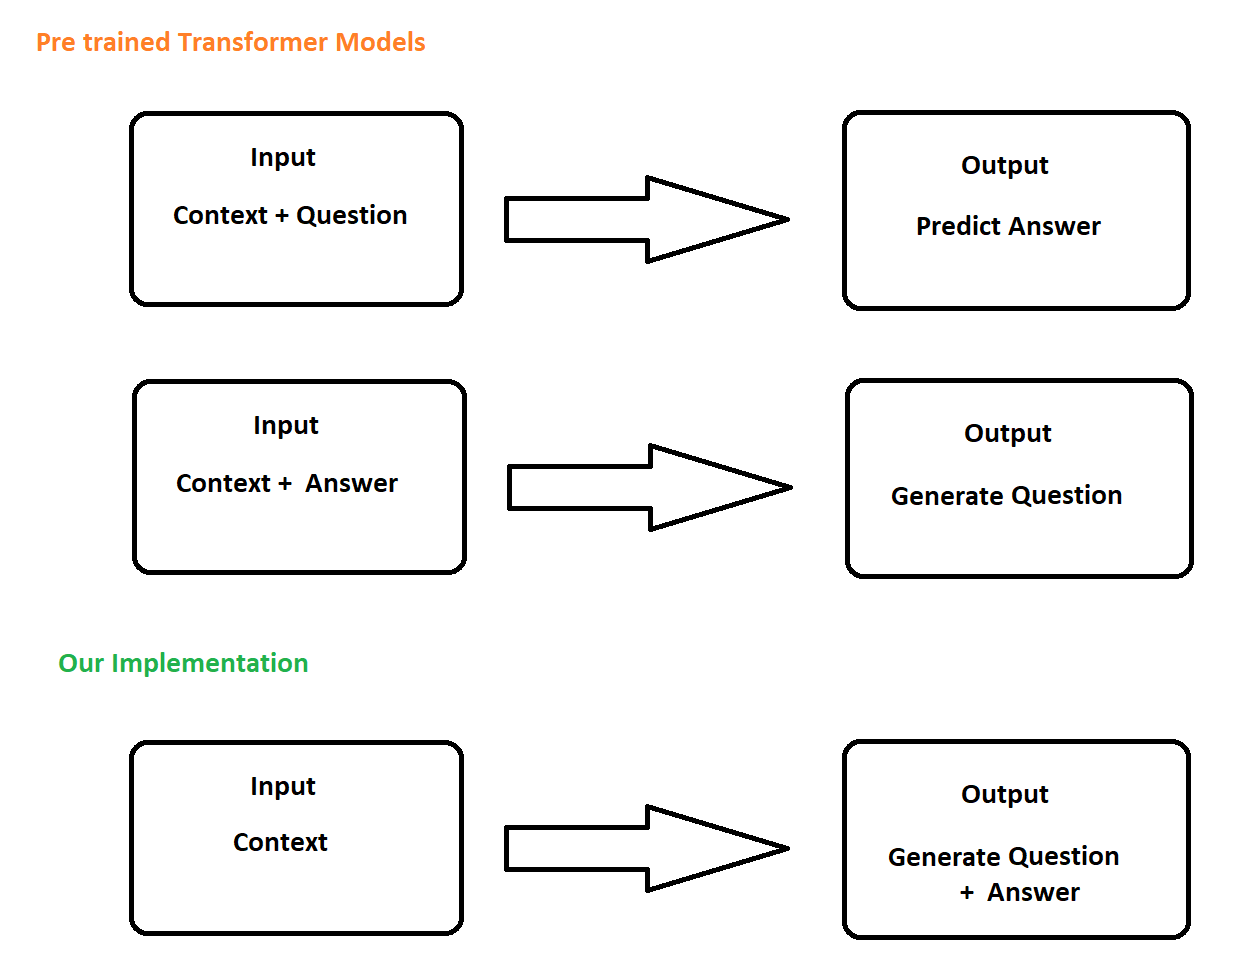

## References

**Haystack Preprocessor**: https://docs.haystack.deepset.ai/docs/preprocessor

**Keyword Extraction**   : https://www.analyticsvidhya.com/blog/2022/03/keyword-extraction-methods-from-documents-in-nlp/

**Yake**                 : http://yake.inesctec.pt/

**KeyBERT**              : https://github.com/MaartenGr/KeyBERT

**Semantic Answer Similarity (SAS)**: https://arxiv.org/abs/2108.06130

**Hugging Face Transformer Models**:

https://huggingface.co/mrm8488/t5-base-finetuned-question-generation-ap

https://huggingface.co/MaRiOrOsSi/t5-base-finetuned-question-answering

https://huggingface.co/sentence-transformers/multi-qa-distilbert-dot-v1

**Based on Research Paper**:  https://arxiv.org/pdf/2005.01107v1.pdf

**Other implementations and ideas** :
https://github.com/patil-suraj/question_generation (End to End QA generation model based on the above research implementation )

**QA generation in Edtech domain** : https://www.youtube.com/watch?v=hoCi_bJHyb8






## Import Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
pd.set_option("display.max_colwidth", -1)
from keybert import KeyBERT
import yake

In [ ]:
# connect your personal google drive to store dataset and trained model
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Import Pre-trained Transformer models

In [ ]:
# Model for question generation given a context and answer (Keyword)

from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-question-generation-ap")
model_qg = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-question-generation-ap")

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [ ]:
# Model for answer generation given a context and question
from  transformers  import  AutoTokenizer, AutoModelWithLMHead, pipeline

model_name = "MaRiOrOsSi/t5-base-finetuned-question-answering"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_qa = AutoModelWithLMHead.from_pretrained(model_name)

In [ ]:
# Model for checking similarity between Context and the answers - Semantic Ansswer Similarity

from sentence_transformers import SentenceTransformer, util
model_sas = SentenceTransformer('sentence-transformers/multi-qa-distilbert-dot-v1')

## Define Functions

In [ ]:
# ----------------PREREQ : Preprocess source using Haystack Framework API as necessary-------------------
def get_source_from_excel(dataset):
  source=pd.read_excel(dataset, sheet_name='Sheet_name_1')
  return source

# ----------------STEP 2 : Define functions for Keyword Extraction --------------------------------------

def keybert_extract(context):
  kw_BERT = KeyBERT()
  bert_keywords = kw_BERT.extract_keywords(context)
  bert_df = pd.DataFrame(bert_keywords, columns =['keyword', 'normalized_weight'])
  return bert_df

def yake_extract(context):
  kw_yake = yake.KeywordExtractor(n=2,top=5)
  yake_keywords = kw_yake.extract_keywords(context)
  yake_df = pd.DataFrame(yake_keywords, columns =['keyword', 'weight']).sort_values(by=['weight', 'keyword'], ascending=[True, False])
  yake_df['normalized_weight'] = 1 - ( yake_df['weight']  / sum(yake_df['weight']))
  yake_df.drop(['weight'], axis=1, inplace = True)
  return yake_df

def get_keywords_from_context(context):
  keywords_df = pd.concat([yake_extract(context), keybert_extract(context)], axis=0)
  return keywords_df

# ----------------STEP 3 : Define functions for Question generation given an answer-----------------------------

def get_question(answer, context, max_length=64):
  input_text = "answer: %s  context: %s </s>" % (answer, context)
  features = tokenizer([input_text], return_tensors='pt')

  output = model_qg.generate(input_ids=features['input_ids'],
               attention_mask=features['attention_mask'],
               max_length=max_length)

  return tokenizer.decode(output[0])

# ----------------STEP 4 : Define functions for Answer prediction given the question-----------------------------

def predict_answers(context, question):
  input = f"question: {question} context: {context}"
  encoded_input = tokenizer([input],
                             return_tensors='pt',
                             max_length=512,
                             truncation=True)
  output = model_qa.generate(input_ids = encoded_input.input_ids,
                            attention_mask = encoded_input.attention_mask)
  output = tokenizer.decode(output[0], skip_special_tokens=True)
  return output


# ----------------STEP 5 : Define functions for generating similarity scores for Original and Predicted Answer ----

# Function to calculate similarity score between the Context and the answers
def get_similarity_scores(question, answers):
  #Encode query and documents
  query_emb = model_sas.encode(question)
  answer_emb = model_sas.encode(answers)
  #Compute dot score between query and all document embeddings
  scores = util.dot_score(query_emb, answer_emb)[0].cpu().tolist()
  return scores

# Function to compare Original and Predicted answer's similarity scores based on a threshold
def check_similarity(score1, score2, threshold):
  if abs(score1-score2) <= threshold :
    return 'Match'
  else:
    return 'No Match'


## Implementation on a Single Context - Step by Step

**Starting from Step 2 - Preprocessing skipped here**

**Step 2 : Extract Keywords**

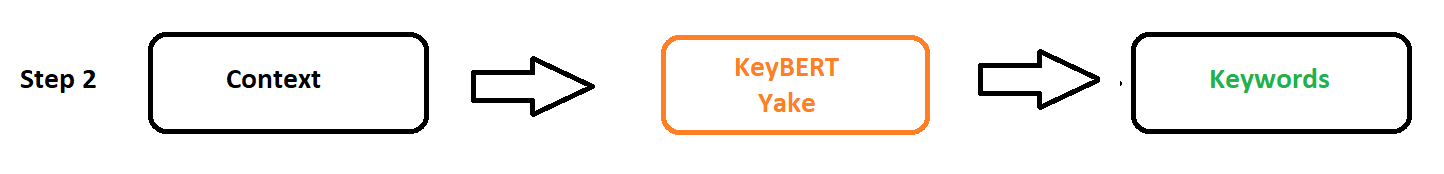

In [ ]:
context = "In 1919 Nancy Astor was elected the first ever female member of parliament to take office in the British Houses of Parliament for the constituency of Plymouth Sutton. Taking over office from her husband Waldorf Astor, Lady Astor was a vibrantly active campaigner for her resident constituents . Plymouth was granted city status on 18 October 1928. The city's first Lord Mayor was appointed in 1935 and its boundaries further expanded in 1967 to include the town of Plympton and the parish of Plymstock."
print(context)

# Get all keywords
all_keywords = get_keywords_from_context(context)

# Filter for keywords with weight > 0.50
keywords = all_keywords[all_keywords["normalized_weight"] > 0.50]
print(keywords)


In 1919 Nancy Astor was elected the first ever female member of parliament to take office in the British Houses of Parliament for the constituency of Plymouth Sutton. Taking over office from her husband Waldorf Astor, Lady Astor was a vibrantly active campaigner for her resident constituents . Plymouth was granted city status on 18 October 1928. The city's first Lord Mayor was appointed in 1935 and its boundaries further expanded in 1967 to include the town of Plympton and the parish of Plymstock.


           keyword  normalized_weight
0  British Houses   0.926385         
1  Nancy Astor      0.891005         
2  Plymouth Sutton  0.874146         
3  Lady Astor       0.663237         
4  female member    0.645227         


**Step 3 : Generate Question for each keyword**

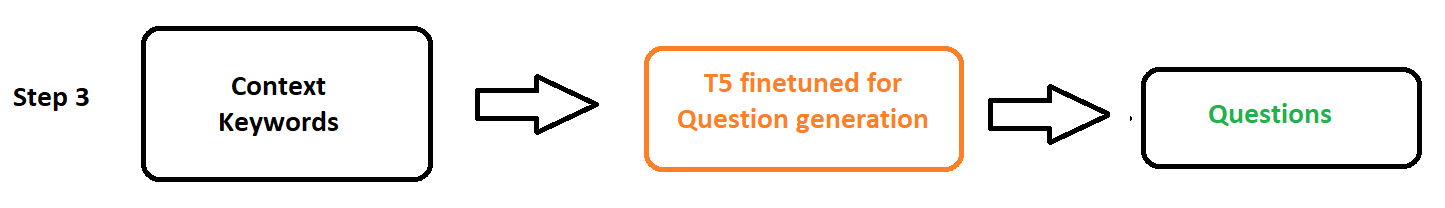

In [ ]:
# Generate Question for each keyword

find_begin = "<pad> question:"
find_end = "</s>"

questions = []

for keyword in keywords['keyword']:
  question = get_question(keyword, context, max_length=64).replace(find_begin,'').replace(find_end,'')
  print('question:', question )
  print('keyword: ', keyword)
  print()
  new_tuple = (context, keyword, question)
  questions.append(new_tuple)


question:  In what house of parliament did Nancy Astor serve?
keyword:  British Houses

question:  Who was the first female member of parliament to take office in the British Houses of Parliament?
keyword:  Nancy Astor

question:  What was Nancy Astor's constituency?
keyword:  Plymouth Sutton

question:  Who was the first female member of parliament to take office in the British Houses of Parliament?
keyword:  Lady Astor

question:  What was Nancy Astor's gender?
keyword:  female member



**Step 4 : Predict Answer for each generated question**

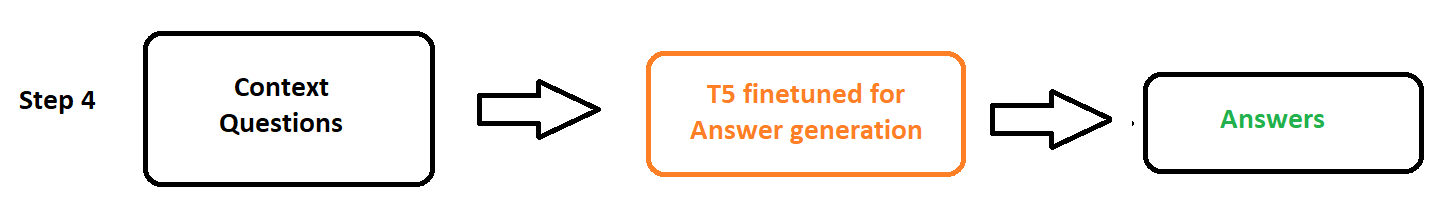

In [ ]:
# Predict Answer for each generated question

answers = []
for context, keyword, question in questions:
    answer = predict_answers(context,question)
    print('keyword:', keyword )
    print('question:', question )
    print('answer: ', answer)
    print()
    new_tuple = (context, keyword, question, answer)
    answers.append(new_tuple)


keyword: British Houses
question:  In what house of parliament did Nancy Astor serve?
answer:  British

keyword: Nancy Astor
question:  Who was the first female member of parliament to take office in the British Houses of Parliament?
answer:  Nancy Astor

keyword: Plymouth Sutton
question:  What was Nancy Astor's constituency?
answer:  Plymouth Sutton

keyword: Lady Astor
question:  Who was the first female member of parliament to take office in the British Houses of Parliament?
answer:  Nancy Astor

keyword: female member
question:  What was Nancy Astor's gender?
answer:  Female



**Step 5 : Calculate Similarity scores and Collect Valid Question Answer pairs**

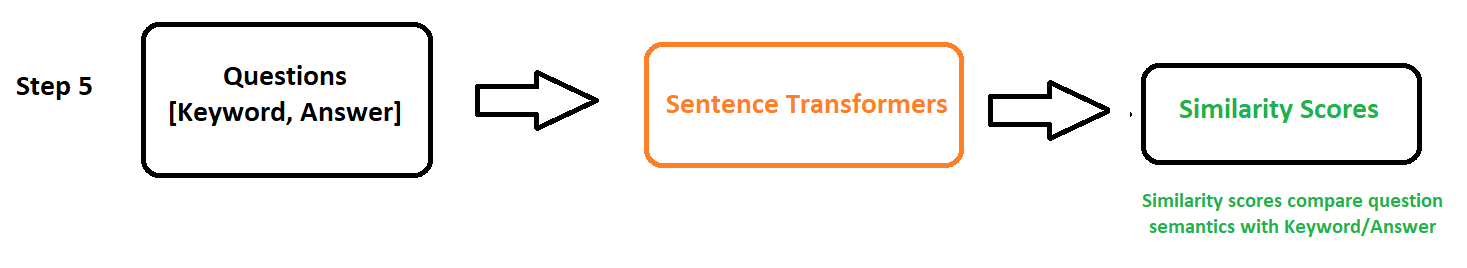

In [ ]:
# Calculate similarity score between the Context and the answers

QA_pairs = []
threshold = 2

for context, keyword, question, answer in answers:
  keyword_answer = [keyword, answer]
  similarity_scores = get_similarity_scores(question, keyword_answer)
  print('keyword:', keyword )
  print('question:', question )
  print('answer: ', answer)
  print('keyword_score: ',similarity_scores[0])
  print('answer_score: ',similarity_scores[1])
  print()
  check = check_similarity(similarity_scores[0], similarity_scores[1], threshold )
  if check == 'Match':
    valid_QA_tuple = (context, question, [keyword, answer], [round(similarity_scores[0],3), round(similarity_scores[1],3)] )
    QA_pairs.append(valid_QA_tuple)


keyword: British Houses
question:  In what house of parliament did Nancy Astor serve?
answer:  British
keyword_score:  16.008066177368164
answer_score:  11.994823455810547

keyword: Nancy Astor
question:  Who was the first female member of parliament to take office in the British Houses of Parliament?
answer:  Nancy Astor
keyword_score:  13.179561614990234
answer_score:  13.179561614990234

keyword: Plymouth Sutton
question:  What was Nancy Astor's constituency?
answer:  Plymouth Sutton
keyword_score:  12.823554992675781
answer_score:  12.823553085327148

keyword: Lady Astor
question:  Who was the first female member of parliament to take office in the British Houses of Parliament?
answer:  Nancy Astor
keyword_score:  13.580570220947266
answer_score:  13.179561614990234

keyword: female member
question:  What was Nancy Astor's gender?
answer:  Female
keyword_score:  15.422765731811523
answer_score:  15.346528053283691



In [ ]:
for context, question, answers, similarity_scores in QA_pairs:
  print('question:', question )
  print('answer: ', set(answers))
  print('similarity_scores: ', similarity_scores)
  print()

question:  Who was the first female member of parliament to take office in the British Houses of Parliament?
answer:  {'Nancy Astor'}
similarity_scores:  [13.18, 13.18]

question:  What was Nancy Astor's constituency?
answer:  {'Plymouth Sutton'}
similarity_scores:  [12.824, 12.824]

question:  Who was the first female member of parliament to take office in the British Houses of Parliament?
answer:  {'Nancy Astor', 'Lady Astor'}
similarity_scores:  [13.581, 13.18]

question:  What was Nancy Astor's gender?
answer:  {'female member', 'Female'}
similarity_scores:  [15.423, 15.347]



## Concise Implementation

In [ ]:
def generate_QA(context, keyword_weight, match_threshold):
  # Get all keywords
  all_keywords = get_keywords_from_context(context)

  # Filter for keywords with weight > 0.50
  keywords = all_keywords[all_keywords["normalized_weight"] > keyword_weight]
  find_begin = "<pad> question:"
  find_end = "</s>"

  questions = []
  for keyword in keywords['keyword']:
    question = get_question(keyword, context, max_length=64).replace(find_begin,'').replace(find_end,'')
    new_tuple = (context, keyword, question)
    questions.append(new_tuple)

  answers = []
  for context, keyword, question in questions:
      answer = predict_answers(context,question)
      new_tuple = (context, keyword, question, answer)
      answers.append(new_tuple)

  QA_pairs = []
  for context, keyword, question, answer in answers:
    keyword_answer = [keyword, answer]
    similarity_scores = get_similarity_scores(question, keyword_answer)
    check = check_similarity(similarity_scores[0], similarity_scores[1], match_threshold )
    if check == 'Match':
      valid_QA_tuple = (context, question, [keyword, answer], [round(similarity_scores[0],3), round(similarity_scores[1],3)] )
      QA_pairs.append(valid_QA_tuple)

  return QA_pairs


In [ ]:
context = "In 1919 Nancy Astor was elected the first ever female member of parliament to take office in the British Houses of Parliament for the constituency of Plymouth Sutton. Taking over office from her husband Waldorf Astor, Lady Astor was a vibrantly active campaigner for her resident constituents . Plymouth was granted city status on 18 October 1928. The city's first Lord Mayor was appointed in 1935 and its boundaries further expanded in 1967 to include the town of Plympton and the parish of Plymstock."
keyword_weight = 0.50
match_threshold = 2
QA_pairs = generate_QA(context, keyword_weight, match_threshold)

# create DataFrame using data
QA = pd.DataFrame(QA_pairs, columns =['context', 'question', 'answer', 'similarity_scores'])
QA


,context,question,answer,similarity_scores
0,"In 1919 Nancy Astor was elected the first ever female member of parliament to take office in the British Houses of Parliament for the constituency of Plymouth Sutton. Taking over office from her husband Waldorf Astor, Lady Astor was a vibrantly active campaigner for her resident constituents . Plymouth was granted city status on 18 October 1928. The city's first Lord Mayor was appointed in 1935 and its boundaries further expanded in 1967 to include the town of Plympton and the parish of Plymstock.",Who was the first female member of parliament to take office in the British Houses of Parliament?,"[Nancy Astor, Nancy Astor]","[13.18, 13.18]"
1,"In 1919 Nancy Astor was elected the first ever female member of parliament to take office in the British Houses of Parliament for the constituency of Plymouth Sutton. Taking over office from her husband Waldorf Astor, Lady Astor was a vibrantly active campaigner for her resident constituents . Plymouth was granted city status on 18 October 1928. The city's first Lord Mayor was appointed in 1935 and its boundaries further expanded in 1967 to include the town of Plympton and the parish of Plymstock.",What was Nancy Astor's constituency?,"[Plymouth Sutton, Plymouth Sutton]","[12.824, 12.824]"
2,"In 1919 Nancy Astor was elected the first ever female member of parliament to take office in the British Houses of Parliament for the constituency of Plymouth Sutton. Taking over office from her husband Waldorf Astor, Lady Astor was a vibrantly active campaigner for her resident constituents . Plymouth was granted city status on 18 October 1928. The city's first Lord Mayor was appointed in 1935 and its boundaries further expanded in 1967 to include the town of Plympton and the parish of Plymstock.",Who was the first female member of parliament to take office in the British Houses of Parliament?,"[Lady Astor, Nancy Astor]","[13.581, 13.18]"
3,"In 1919 Nancy Astor was elected the first ever female member of parliament to take office in the British Houses of Parliament for the constituency of Plymouth Sutton. Taking over office from her husband Waldorf Astor, Lady Astor was a vibrantly active campaigner for her resident constituents . Plymouth was granted city status on 18 October 1928. The city's first Lord Mayor was appointed in 1935 and its boundaries further expanded in 1967 to include the town of Plympton and the parish of Plymstock.",What was Nancy Astor's gender?,"[female member, Female]","[15.423, 15.347]"


## Sample Implementation on a single paragraph a from Biology Textbook

Text from Chapter - Chemistry of Life

In [ ]:
context = "Atoms are the building blocks that come together through chemical bonding to form molecules in the universe. In this model of a molecule, the atoms of carbon (black), hydrogen (white), nitrogen (blue), oxygen (red), and sulfur (yellow) are in proportional atomic size. The silver rods indicate chemical bonds that hold the atoms together in a specific three-dimensional shape. (credit: modification of work by Christian Guthier). The elements carbon, hydrogen, nitrogen, oxygen, sulfur, and phosphorus are the key building blocks found in all living things."

keyword_weight = 0.50
match_threshold = 2
QA_pairs = generate_QA(context, keyword_weight, match_threshold)

# create DataFrame using data
QA = pd.DataFrame(QA_pairs, columns =['context', 'question', 'answer', 'similarity_scores'])


In [ ]:
QA

,context,question,answer,similarity_scores
0,"Atoms are the building blocks that come together through chemical bonding to form molecules in the universe. In this model of a molecule, the atoms of carbon (black), hydrogen (white), nitrogen (blue), oxygen (red), and sulfur (yellow) are in proportional atomic size. The silver rods indicate chemical bonds that hold the atoms together in a specific three-dimensional shape. (credit: modification of work by Christian Guthier). The elements carbon, hydrogen, nitrogen, oxygen, sulfur, and phosphorus are the key building blocks found in all living things.",Atoms are the building blocks that come together through chemical bonding to do what in the universe?,"[form molecules, form molecules]","[19.808, 19.808]"
1,"Atoms are the building blocks that come together through chemical bonding to form molecules in the universe. In this model of a molecule, the atoms of carbon (black), hydrogen (white), nitrogen (blue), oxygen (red), and sulfur (yellow) are in proportional atomic size. The silver rods indicate chemical bonds that hold the atoms together in a specific three-dimensional shape. (credit: modification of work by Christian Guthier). The elements carbon, hydrogen, nitrogen, oxygen, sulfur, and phosphorus are the key building blocks found in all living things.",How do atoms come together?,"[chemical bonding, Chemical bonding]","[18.137, 18.137]"
2,"Atoms are the building blocks that come together through chemical bonding to form molecules in the universe. In this model of a molecule, the atoms of carbon (black), hydrogen (white), nitrogen (blue), oxygen (red), and sulfur (yellow) are in proportional atomic size. The silver rods indicate chemical bonds that hold the atoms together in a specific three-dimensional shape. (credit: modification of work by Christian Guthier). The elements carbon, hydrogen, nitrogen, oxygen, sulfur, and phosphorus are the key building blocks found in all living things.",What are atoms?,"[building blocks, Building blocks]","[12.867, 12.867]"
3,"Atoms are the building blocks that come together through chemical bonding to form molecules in the universe. In this model of a molecule, the atoms of carbon (black), hydrogen (white), nitrogen (blue), oxygen (red), and sulfur (yellow) are in proportional atomic size. The silver rods indicate chemical bonds that hold the atoms together in a specific three-dimensional shape. (credit: modification of work by Christian Guthier). The elements carbon, hydrogen, nitrogen, oxygen, sulfur, and phosphorus are the key building blocks found in all living things.",What are the building blocks that come together through chemical bonding to form molecules in the universe?,"[Atoms, Atoms]","[17.194, 17.194]"
4,"Atoms are the building blocks that come together through chemical bonding to form molecules in the universe. In this model of a molecule, the atoms of carbon (black), hydrogen (white), nitrogen (blue), oxygen (red), and sulfur (yellow) are in proportional atomic size. The silver rods indicate chemical bonds that hold the atoms together in a specific three-dimensional shape. (credit: modification of work by Christian Guthier). The elements carbon, hydrogen, nitrogen, oxygen, sulfur, and phosphorus are the key building blocks found in all living things.",Who modified the model of atoms?,"[Christian Guthier, Christian Guthier]","[9.92, 9.92]"
5,"Atoms are the building blocks that come together through chemical bonding to form molecules in the universe. In this model of a molecule, the atoms of carbon (black), hydrogen (white), nitrogen (blue), oxygen (red), and sulfur (yellow) are in proportional atomic size. The silver rods indicate chemical bonds that hold the atoms together in a specific three-dimensional shape. (credit: modification of work by Christian Guthier). The elements carbon, hydrogen, nitrogen, oxygen, sulfur, and phosphorus are the key building blocks found in all living things.",What are the building blocks that come

## Implementation for the entire Biology chapter - "Chemistry Of Life"

In [ ]:
#source = get_source_from_excel("/content/gdrive/My Drive/CS 677 Project/dataset/chemistryoflife_v3.xlsx")
#
#QA_full = []
#
#for index, row in source.iterrows():
#  context = row['content']
#  keyword_weight = 0.20
#  match_threshold = 1.5
#  QA_pairs = generate_QA(context, keyword_weight, match_threshold)
#  QA = pd.DataFrame(QA_pairs, columns =['context', 'question', 'answer', 'similarity_scores'])
#  QA_full.append(QA)
#
#final_QA_pairs = pd.concat(QA_full)
#final_QA_pairs.to_excel("/content/gdrive/My Drive/CS 677 Project/dataset/final_QA.xlsx", sheet_name='Sheet_name_1')

In [ ]:
#final_QA_pairs